## HLCM 2 - with saved network vars
Arezoo Besharati, UrbanSim, July 2018 


In [1]:
import os; os.chdir('../../')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
warnings.simplefilter('ignore')

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

### Load data

In [3]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [4]:
#mm.list_steps()

In [5]:
#mm.initialize()

In [6]:
orca.list_tables()
#orca.list_broadcasts()
#orca.list_steps()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'nodessmall',
 'nodeswalk',
 'units',
 'households',
 'persons',
 'jobs']

### Load accessibility vars

In [7]:
%%capture
orca.run(["initialize_network_walk"])

In [8]:
%%capture
orca.run(["initialize_network_small"])

### Explore the data

In [9]:
bld = orca.get_table('buildings').to_frame()
bld.columns.tolist()

['parcel_id',
 'development_type_id',
 'improvement_value',
 'residential_units',
 'residential_sqft',
 'sqft_per_unit',
 'non_residential_sqft',
 'building_sqft',
 'nonres_rent_per_sqft',
 'res_price_per_sqft',
 'stories',
 'year_built',
 'redfin_sale_price',
 'redfin_sale_year',
 'redfin_home_type',
 'costar_property_type',
 'costar_rent',
 'building_type_id',
 'res_sqft_per_unit',
 'node_id_walk',
 'node_id_small']

In [10]:
hh = orca.get_table('households').to_frame()
hh.columns.tolist()

['serialno',
 'persons',
 'building_type',
 'cars',
 'income',
 'race_of_head',
 'hispanic_head',
 'age_of_head',
 'workers',
 'state',
 'county',
 'tract',
 'block_group',
 'children',
 'tenure',
 'recent_mover',
 'block_group_id',
 'single_family',
 'unit_id',
 'building_id',
 'node_id_walk',
 'node_id_small']

In [11]:
# scale the income
hh.income_cl= hh.income/1000
# update the column
orca.get_table('households').update_col_from_series('income', hh.income_cl)

In [12]:
#bld.building_type_id.value_counts()

In [13]:
nodeswalk= orca.get_table('nodeswalk').to_frame()
nodessmall= orca.get_table('nodessmall').to_frame()
print(nodeswalk.columns.tolist())
print(nodessmall.columns.tolist())

['units_500_walk', 'sqft_unit_500_walk', 'singles_500_walk', 'elderly_hh_500_walk', 'children_500_walk', 'units_sf_500_walk', 'units_mf_500_walk', 'pop_500_walk', 'hh_500_walk', 'poor_500_walk', 'rich_500_walk', 'renters_500_walk', 'med_income_500_walk', 'jobs_500_walk', 'med_rent_500_walk', 'pop_white_500_walk', 'pop_black_500_walk', 'pop_asian_500_walk', 'pop_hisp_500_walk', 'units_1500_walk', 'sqft_unit_1500_walk', 'singles_1500_walk', 'elderly_hh_1500_walk', 'children_1500_walk', 'units_sf_1500_walk', 'units_mf_1500_walk', 'pop_1500_walk', 'hh_1500_walk', 'poor_1500_walk', 'rich_1500_walk', 'renters_1500_walk', 'med_income_1500_walk', 'jobs_1500_walk', 'med_rent_1500_walk', 'pop_white_1500_walk', 'pop_black_1500_walk', 'pop_asian_1500_walk', 'pop_hisp_1500_walk']
['units_10000', 'units_sf_10000', 'units_mf_10000', 'pop_10000', 'hh_10000', 'poor_10000', 'renters_10000', 'med_income_10000', 'jobs_10000', 'med_rent_10000', 'pop_white_10000', 'pop_black_10000', 'pop_asian_10000', 'pop_

In [14]:
#bld.stories.value_counts().plot(kind='bar')
#bld.stories.value_counts()

## Get the predicted price from REPM

In [15]:
#orca.run(['hedonic_rent_sqft'])

## Model Estimation

In [16]:
%%time
m = LargeMultinomialLogitStep()
m.choosers = ['households']
m.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m.choice_column = 'building_id'
m.alt_sample_size = 500

#Filters on choosers
m.chooser_filters = ['household_id <100000 & recent_mover == 1 & 0 <income < 600000']

#Filters on alternatives
m.alt_filters = ['residential_units!=0',
                 '0 < med_income_500_walk < 200000',
                 'sqft_per_unit > 0',
                 'year_built > 1700',
                 'stories > 0']

m.model_expression = 'np.log1p(res_price_per_sqft)+ np.cbrt(pop_500_walk) +\
np.log1p(jobs_1500_walk) + np.log(med_income_500_walk):np.log(income) +np.log1p(jobs_25000)+\
np.log1p(pop_black_1500_walk)+ building_type_id==1 + year_built<1950 + stories<4 + np.log1p(sqft_per_unit) - 1'

m.name = 'hlcm'
m.tags = ['arezoo', 'test']
m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,561
Model:         Multinomial Logit   Df Residuals:              2,550
Method:       Maximum Likelihood   Df Model:                     11
Date:                 2018-07-18   Pseudo R-squ.:             0.315
Time:                      14:09   Pseudo R-bar-squ.:         0.314
AIC:                  21,821.783   Log-Likelihood:      -10,899.891
BIC:                  21,886.112   LL-Null:             -15,915.611
                                                coef   std err         z     P>|z|   Conf. Int.
-----------------------------------------------------------------------------------------------
building_type_id == 1[False]                  1.1757     4.398     0.267     0.789             
building_type_id == 1[True]                  -1.1757     4.397    -0.267     0.789             
year_built < 1950[T.True]                    -0.4912     0.057    -8.636

In [17]:
%%time
m = LargeMultinomialLogitStep()
m.choosers = ['households']
m.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m.choice_column = 'building_id'
m.alt_sample_size = 500

#Filters on choosers
m.chooser_filters = ['household_id <100000 & recent_mover == 1 & 0 <income < 600000']

#Filters on alternatives
m.alt_filters = ['residential_units!=0',
                 '0 < med_income_500_walk < 200000',
                 'sqft_per_unit > 0',
                 'year_built > 1700',
                 'stories > 0']

m.model_expression = 'np.log1p(res_price_per_sqft)+\
np.log1p(jobs_1500_walk) + np.log(med_income_500_walk) +np.log1p(jobs_25000)+\
np.log1p(pop_black_1500_walk)+ I(building_type_id==1) + year_built<1950 + year_built>2000+stories + np.log1p(sqft_per_unit) - 1'

m.name = 'hlcm'
m.tags = ['arezoo', 'test']
m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,561
Model:         Multinomial Logit   Df Residuals:              2,550
Method:       Maximum Likelihood   Df Model:                     11
Date:                 2018-07-18   Pseudo R-squ.:             0.323
Time:                      14:10   Pseudo R-bar-squ.:         0.322
AIC:                  21,582.825   Log-Likelihood:      -10,780.413
BIC:                  21,647.155   LL-Null:             -15,915.611
                                     coef   std err         z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------
I(building_type_id == 1)[False]    1.0745     4.859     0.221     0.825             
I(building_type_id == 1)[True]    -1.0745     4.860    -0.221     0.825             
year_built < 1950[T.True]         -0.2495     0.060    -4.135     0.000             
year_built > 2000[T.True]      

In [21]:
%%time
m = LargeMultinomialLogitStep()
m.choosers = ['households']
m.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m.choice_column = 'building_id'
m.alt_sample_size = 500

#Filters on choosers
m.chooser_filters = ['household_id <100000 & recent_mover == 1 & 0 <income < 600000']

#Filters on alternatives
m.alt_filters = ['residential_units!=0',
                 '0 < med_income_500_walk < 200000',
                 'sqft_per_unit > 0',
                 'year_built > 1700',
                 'stories > 0']

m.model_expression = 'np.log1p(res_price_per_sqft)+\
np.log1p(jobs_1500_walk) + np.log(med_income_500_walk) +np.log1p(jobs_25000)+\
np.log1p(pop_black_1500_walk)+ I(building_type_id==1) + year_built<1950 + year_built>2000+stories  - 1'

m.name = 'hlcm'
m.tags = ['arezoo', 'test']
m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          2,561
Model:         Multinomial Logit   Df Residuals:              2,551
Method:       Maximum Likelihood   Df Model:                     10
Date:                 2018-07-18   Pseudo R-squ.:             0.323
Time:                      14:12   Pseudo R-bar-squ.:         0.323
AIC:                  21,556.799   Log-Likelihood:      -10,768.400
BIC:                  21,615.281   LL-Null:             -15,915.611
                                     coef   std err         z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------
I(building_type_id == 1)[False]    1.0709     4.751     0.225     0.822             
I(building_type_id == 1)[True]    -1.0709     4.752    -0.225     0.822             
year_built < 1950[T.True]         -0.2446     0.060    -4.058     0.000             
year_built > 2000[T.True]      

In [18]:
## Check for multicolinearity

In [19]:
df = orca.merge_tables(target = 'buildings', tables = ['buildings','parcels','nodeswalk','nodessmall'])


<IPython.core.display.Javascript object>


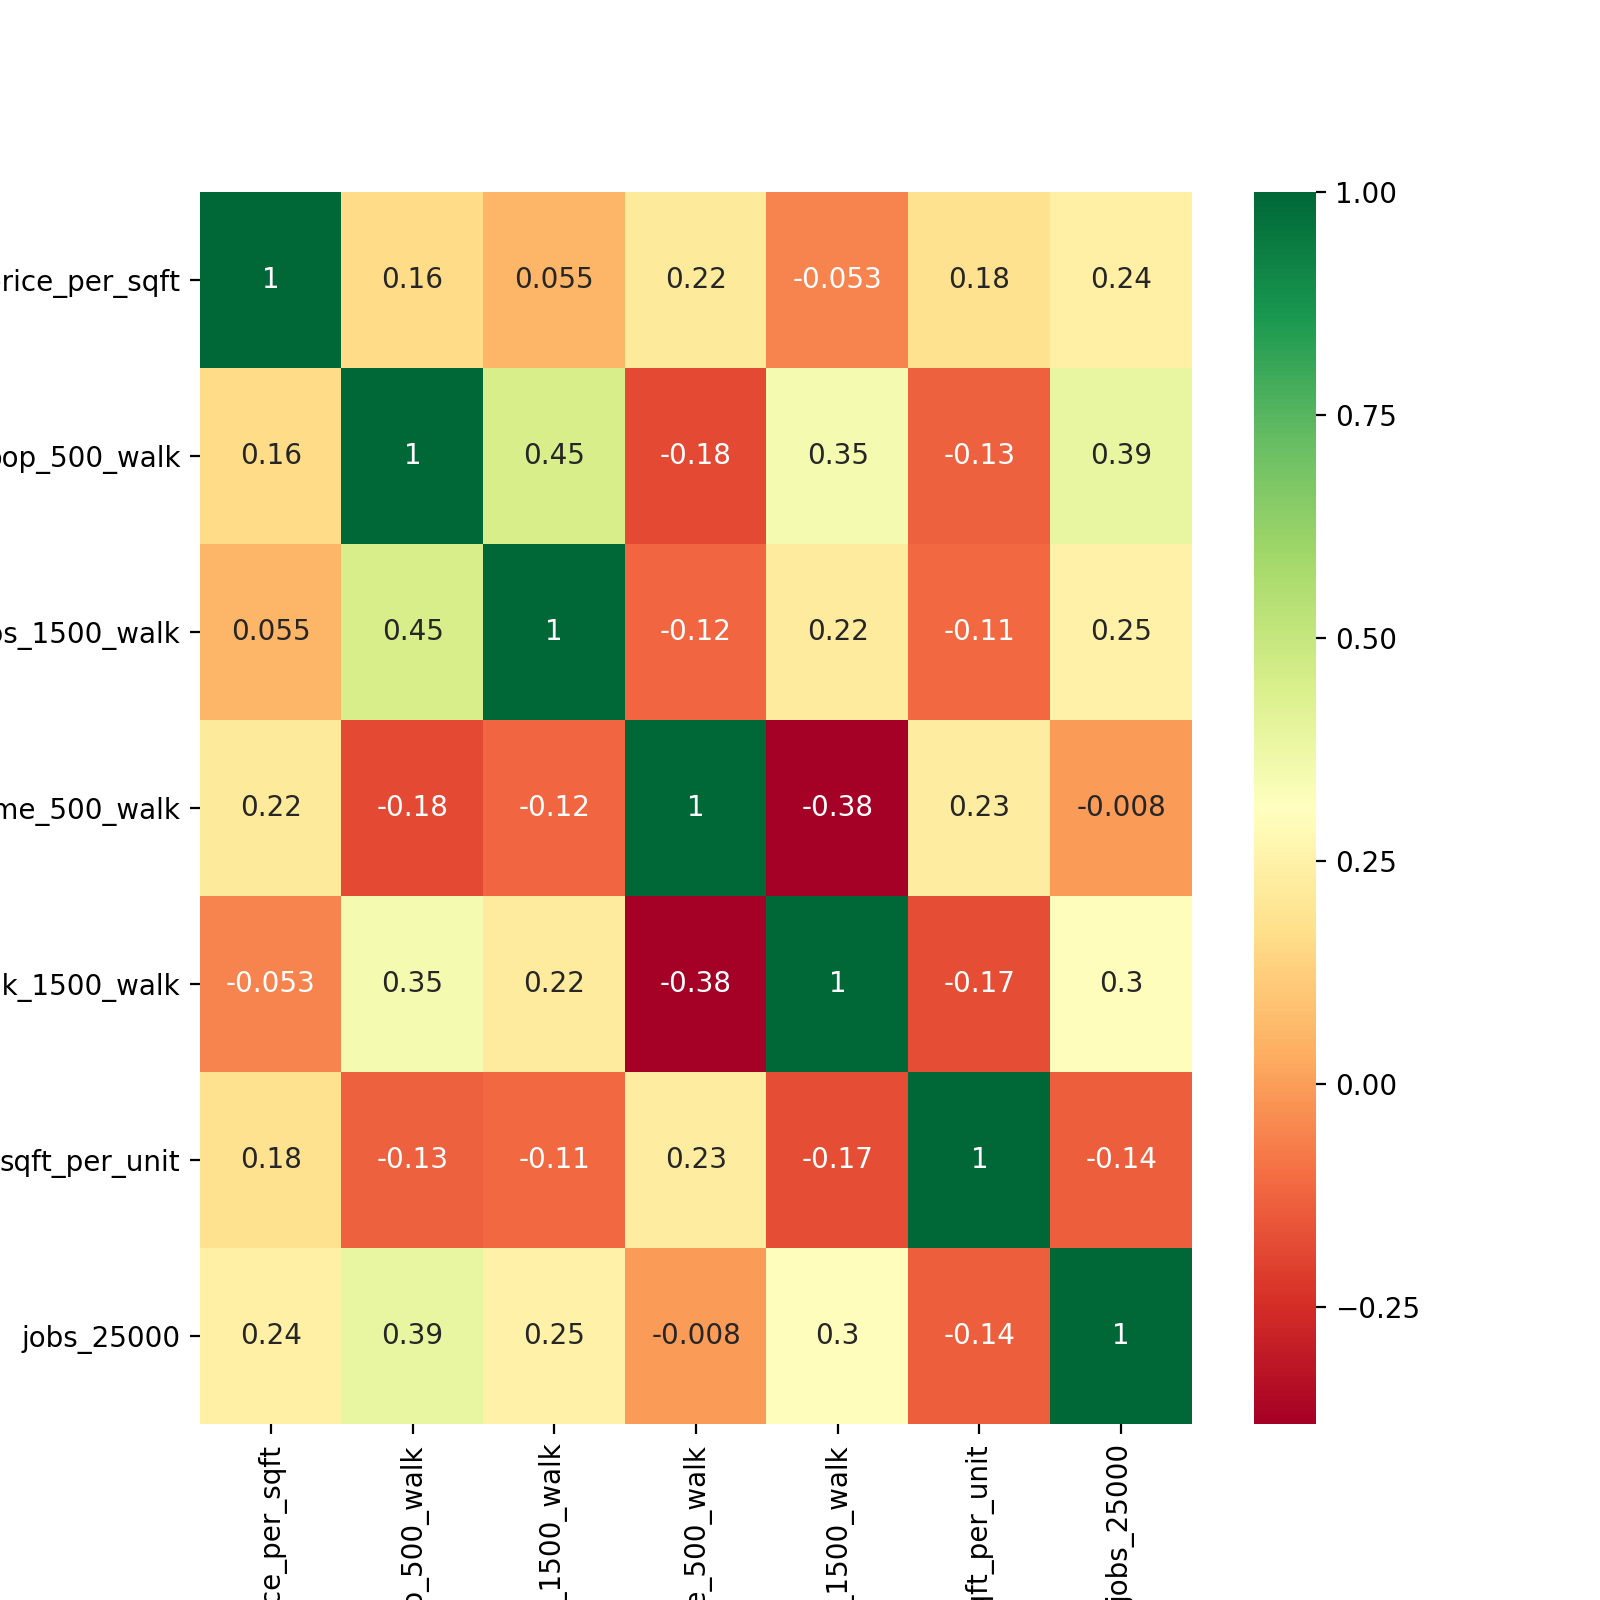

In [20]:
Selected_features = ['res_price_per_sqft', 'pop_500_walk', 'jobs_1500_walk',
                     'med_income_500_walk','pop_black_1500_walk', 'sqft_per_unit','jobs_25000']
X = df[Selected_features]

plt.subplots(figsize=(8, 8))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()